<a href="https://colab.research.google.com/github/yusrialsanaani/Pedestrian_Detection_Using_Faster_RCNN/blob/main/Pedestrian_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pedestrian Detection using Faster RCNN

In [1]:
import torch
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
import torch
cuda_enable = True
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [4]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from pycocotools.coco import COCO
from torchvision import datasets, transforms, models

In [5]:
!git clone https://github.com/yusrialsanaani/Pedestrian.git

Cloning into 'Pedestrian'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 333 (delta 3), reused 105 (delta 2), pack-reused 227
Receiving objects: 100% (333/333), 86.48 MiB | 16.70 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [6]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 125919, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 125919 (delta 0), reused 1 (delta 0), pack-reused 125918
Receiving objects: 100% (125919/125919), 246.89 MiB | 39.44 MiB/s, done.
Resolving deltas: 100% (110024/110024), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [7]:
from engine import train_one_epoch, evaluate
import utils

## Dataset Preparation

In [8]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, root, annotation, transforms=None):
    self.root = root
    self.transforms = transforms
    self.coco = COCO(annotation)
    self.ids = list(sorted(self.coco.imgs.keys()))

  def __getitem__(self, idx):
    # image ID
    img_id = self.ids[idx]
    # image file_name
    img_file = self.coco.loadImgs(img_id)[0]["file_name"]
    # read_imgae
    img = Image.open(os.path.join(self.root, img_file))
    # get annotation ID
    ann_ids = self.coco.getAnnIds(imgIds = img_id)
    # read annotation
    anns = self.coco.loadAnns(ann_ids)
    # num of people in the picture
    num_objs = len(anns)
    # build information about bounding box & area
    boxes = []
    areas = []
    for i in range(num_objs):
      x_min = anns[i]['bbox'][0]
      y_min = anns[i]['bbox'][1]
      x_max = x_min + anns[i]['bbox'][2]
      y_max = y_min + anns[i]['bbox'][3]
      boxes.append([x_min, y_min, x_max, y_max])
      areas.append(anns[i]['area'])
  
    # transfer information to Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((num_objs,), dtype = torch.int64)
    img_id = torch.tensor([img_id])
    areas = torch.as_tensor(areas, dtype=torch.float32)
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    # Annotation in dict form
    Annotations = {
        "boxes" : boxes,
        "labels" : labels,
        "image_id" : img_id,
        "area" : areas,
        "iscrowd" : iscrowd
    }

    # transforms
    if self.transforms is not None:
      img = self.transforms(img)
    
    return img, Annotations
  
  def __len__(self):
    return len(self.ids)

## Image Transformation

In [9]:
def get_transforms(train):
  trans = []
  if train:
    trans.append(transforms.RandomHorizontalFlip(0.5))
    # trans.append(transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)))
    # trans.append(transforms.ColorJitter(brightness=1, contrast=1, saturation=1))
  trans.append(transforms.ToTensor())
  return transforms.Compose(trans)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
train_data_path = '/content/drive/MyDrive/Colab Notebooks/Pedestrian_Detection/WiderPerson/Images'
coco_path       = '/content/drive/MyDrive/Colab Notebooks/Pedestrian_Detection/WiderPerson/train.json'
test_path       = '/content/Pedestrian/TestImages'

In [13]:
train_data_path1 = '/content/Pedestrian/PNGImages'
coco_path1       = '/content/Pedestrian/Json/train.json'
test_path       = '/content/Pedestrian/TestImages'

In [16]:
train_dataset = ImageDataset(root=train_data_path1, annotation = coco_path1, transforms = get_transforms(train=True));
test_dataset  = ImageDataset(root=train_data_path1, annotation = coco_path1, transforms = get_transforms(train=False));

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [17]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(test_dataset)}\n")

Number of training samples: 269
Number of validation samples: 269



In [18]:
# Split the dataset into train and test sets as 80:20
train_size = int(0.9 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

In [19]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(test_dataset)}\n")

Number of training samples: 242
Number of validation samples: 27



In [20]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 2, shuffle = True, collate_fn=collate_fn)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size = 1, shuffle = False, collate_fn=collate_fn)

In [21]:
# Constructs a Faster R-CNN model with a ResNet-50-FPN backbone.
# # load a model pre-trained on COCO
model1 = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [22]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# change question to binary classification (human, not human)
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2
# get number of input features for the classifier
in_features = model1.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model1.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# move model to the right device
# model.to(device)
model1 = model1.to(device)

In [23]:
# construct an optimizer
params = [p for p in model1.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [24]:
# And now let's train the model for 15 epochs, evaluating at the end of every epoch.

epochs = 15
for epoch in range(epochs):
  model1.train()
  i = 0
  for imgs, annotations in train_loader:
    i += 1
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k:v.to(device) for k, v in t.items()} for t in annotations]
    loss_dict = model1(imgs, annotations)
    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()
    #train_loss_list.append(loss_value)
    #train_loss_hist.send(loss_value)

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    print("Iteration: {}; Loss: {}".format(i, losses))
  lr_scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration: 1; Loss: 2.214247465133667
Iteration: 2; Loss: 0.6730147004127502
Iteration: 3; Loss: 0.47930702567100525
Iteration: 4; Loss: 2.2176008224487305
Iteration: 5; Loss: 1.3206114768981934
Iteration: 6; Loss: 0.29444047808647156
Iteration: 7; Loss: 0.916034460067749
Iteration: 8; Loss: 1.2128950357437134
Iteration: 9; Loss: 0.41643601655960083
Iteration: 10; Loss: 1.3376355171203613
Iteration: 11; Loss: 0.32942020893096924
Iteration: 12; Loss: 0.2224598228931427
Iteration: 13; Loss: 0.37269750237464905
Iteration: 14; Loss: 1.0839285850524902
Iteration: 15; Loss: 0.8467143177986145
Iteration: 16; Loss: 0.728291392326355
Iteration: 17; Loss: 0.3738008141517639
Iteration: 18; Loss: 0.7825666666030884
Iteration: 19; Loss: 0.2913961708545685
Iteration: 20; Loss: 0.8041395545005798
Iteration: 21; Loss: 0.8643065094947815
Iteration: 22; Loss: 0.1308264434337616
Iteration: 23; Loss: 0.49778199195861816
Iteration: 24; Loss: 0.3193422853946686
Iteration: 25; Loss: 0.30451929569244385
Itera

In [25]:
# Constructs a Faster R-CNN model with a ResNet-50-FPN backbone.
# # load a model pre-trained on COCO
model2 = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# change question to binary classification (human, not human)
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2
# get number of input features for the classifier
in_features = model2.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model2.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# move model to the right device
# model.to(device)
model2 = model2.to(device)

# construct an optimizer
params = [p for p in model2.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [26]:
#train_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
#test_loader  = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [27]:
# And now let's train the model for 15 epochs, evaluating at the end of every epoch.
epochs = 15
for epoch in range(epochs):
  train_one_epoch(model2, optimizer, train_loader, device, epoch, print_freq=50)
  # update the learning rate
  lr_scheduler.step()
  # evaluate on the test dataset    
  evaluate(model2, test_loader, device=device)    
    
  print('')
  print('==================================================')
  print('')

  

Epoch: [0]  [  0/121]  eta: 0:00:43  lr: 0.000047  loss: 1.4991 (1.4991)  loss_classifier: 0.9336 (0.9336)  loss_box_reg: 0.5217 (0.5217)  loss_objectness: 0.0267 (0.0267)  loss_rpn_box_reg: 0.0171 (0.0171)  time: 0.3604  data: 0.0179  max mem: 4414
Epoch: [0]  [ 50/121]  eta: 0:00:24  lr: 0.002128  loss: 0.7929 (0.9602)  loss_classifier: 0.1984 (0.3662)  loss_box_reg: 0.3122 (0.4088)  loss_objectness: 0.0855 (0.1344)  loss_rpn_box_reg: 0.0255 (0.0508)  time: 0.3493  data: 0.0209  max mem: 4414
Epoch: [0]  [100/121]  eta: 0:00:07  lr: 0.004209  loss: 0.5080 (0.7841)  loss_classifier: 0.1227 (0.2829)  loss_box_reg: 0.2923 (0.3613)  loss_objectness: 0.0247 (0.0973)  loss_rpn_box_reg: 0.0182 (0.0426)  time: 0.3428  data: 0.0207  max mem: 4414
Epoch: [0]  [120/121]  eta: 0:00:00  lr: 0.005000  loss: 0.5917 (0.7539)  loss_classifier: 0.1486 (0.2667)  loss_box_reg: 0.3001 (0.3537)  loss_objectness: 0.0389 (0.0923)  loss_rpn_box_reg: 0.0241 (0.0413)  time: 0.3368  data: 0.0210  max mem: 4414


yes, I read about it. The values as stated are average precision and average recall on IoU(intersection over union) thresholds between 0.5 and 0.95 where maximum detections over which it is calculated is 100. In other words, precision is calculated over number of positive detections (greater than IoU threshold) by total number of TPs and FPs. and then the average of precision values over each threshold is calculated to obtain the final value in the last column.
Similarly for recall.
Also, they have calculated Average Precision (AP) and AR over different areas (all, small, medium and large)

https://github.com/matterport/Mask_RCNN/issues/663

https://datascience.stackexchange.com/questions/16797/what-does-the-notation-map-5-95-mean



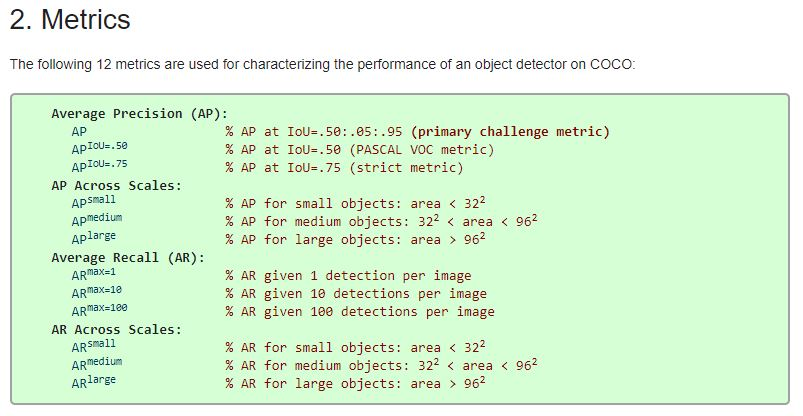

In [28]:
def im_convert(tensor):
    image = tensor.clone().detach().cpu().numpy()
    
    # [C, W, H] --> [W, H, C]
    image = image.transpose(1, 2, 0)

    # denormalize
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))

    # Set the maximum and minimum values of image to [0, 1] if it exceeds 1, it is set to 1 / if it is less than 0, it is set to 0
    image = image.clip(0, 1)
    
    return image

In [29]:
from PIL import Image
import cv2


In [30]:
image = cv2.imread("/content/Pedestrian/TestImages/PennPed00080.png")

In [31]:
 
img = cv2.imread("/content/Pedestrian/TestImages/10.jpg")
dim = (4496,3000)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

print('Resized Dimensions : ',resized.shape)

Resized Dimensions :  (3000, 4496, 3)


In [40]:
dim = (4496,3000)
img = cv2.imread("/content/Pedestrian/TestImages/10.jpg")
if img.shape<(3000, 4496):
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  print('resized')

In [33]:
img.shape

(3000, 4496, 3)

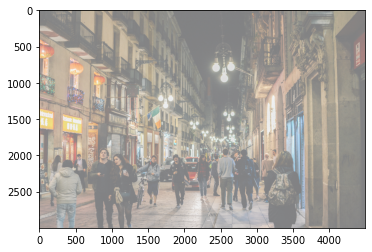

In [46]:
import cv2
from google.colab.patches import cv2_imshow

# use 10.pic to illustrate performance for a single picture.
#img = cv2.imread("/content/Pedestrian/TestImages/10.jpg")
dim = (4496,3000)
img = cv2.imread("/content/Pedestrian/TestImages/10.jpg")
if img.shape<(3000, 4496):
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  print('resized')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# transfer array to pillow format
val_tran = get_transforms(train=False)
im_pil = Image.fromarray(img)
im_pil = val_tran(im_pil)
plt.imshow(im_convert(im_pil))

image = im_pil.to(device)
model_val = model1.eval()
output = model1([image])
#print(output)

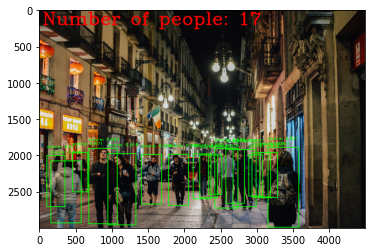

True

In [47]:
scores = output[0]['scores'].detach().cpu().numpy()
num_people = len(scores[scores > 0.5])

boxes = output[0]['boxes'].detach().cpu().numpy()
boxes = boxes[:num_people]

for i in range(num_people):
  img = cv2.rectangle(img, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), (0, 255, 0), thickness=10)
  img = cv2.putText(img, "score: {:.3f}".format(scores[i]), (boxes[i][0], int(boxes[i][1] - 100)),
                    cv2.FONT_HERSHEY_PLAIN, 4, (0, 255, 0), thickness=5)

img = cv2.putText(img,"Number of people: {}".format(num_people), (50, 200),
                  cv2.FONT_HERSHEY_COMPLEX, 8, (255, 0, 0), thickness=15)

plt.imshow(img)
plt.show()
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output.jpg', img)

In [48]:
# config.py
import torch
NUM_EPOCHS = 50 # number of epochs to train for
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# training images and XML files directory
TRAIN_DIR = '/content/Pedestrian/PNGImages'
# validation images and XML files directory
VALID_DIR = '/content/Pedestrian/TestImages'
# classes: 0 index is reserved for background

NUM_CLASSES = 2

# location to save model and plots
OUT_DIR = '/content/Pedestrian/Output'
SAVE_PLOTS_EPOCH = 1 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 1 # save model after these many epochs

In [49]:
import albumentations as A
import cv2
import numpy as np
#from albumentations.pytorch import ToTensorV2
#from config import DEVICE, CLASSES as classes

In [50]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [51]:

# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [52]:
# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })
# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [53]:
valid_loader = test_loader;

In [54]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [55]:
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
import time
plt.style.use('ggplot')

In [56]:
# function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [57]:
# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [58]:
NUM_EPOCHS = 15


EPOCH 1 of 15
Training


  0%|          | 0/121 [00:00<?, ?it/s]

Validating


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch #0 train loss: 0.720
Epoch #0 validation loss: 0.661
Took 0.698 minutes for epoch 0
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 2 of 15
Training


  0%|          | 0/121 [00:00<?, ?it/s]

Validating


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch #1 train loss: 0.585
Epoch #1 validation loss: 0.608
Took 0.696 minutes for epoch 1
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 3 of 15
Training


  0%|          | 0/121 [00:00<?, ?it/s]

Validating


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch #2 train loss: 0.583
Epoch #2 validation loss: 0.596
Took 0.706 minutes for epoch 2
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 4 of 15
Training


  0%|          | 0/121 [00:00<?, ?it/s]

Validating


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch #3 train loss: 0.543
Epoch #3 validation loss: 0.636
Took 0.699 minutes for epoch 3
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 5 of 15
Training


  0%|          | 0/121 [00:00<?, ?it/s]

Validating


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch #4 train loss: 0.539
Epoch #4 validation loss: 0.646
Took 0.698 minutes for epoch 4
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 6 of 15
Training


  0%|          | 0/121 [00:00<?, ?it/s]

Validating


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch #5 train loss: 0.540
Epoch #5 validation loss: 0.708
Took 0.697 minutes for epoch 5
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 7 of 15
Training


  0%|          | 0/121 [00:00<?, ?it/s]

Validating


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch #6 train loss: 0.510
Epoch #6 validation loss: 0.668
Took 0.702 minutes for epoch 6
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 8 of 15
Training


  0%|          | 0/121 [00:00<?, ?it/s]

Validating


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch #7 train loss: 0.498
Epoch #7 validation loss: 0.709
Took 0.705 minutes for epoch 7
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 9 of 15
Training


  0%|          | 0/121 [00:00<?, ?it/s]

Validating


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch #8 train loss: 0.522
Epoch #8 validation loss: 0.635
Took 0.697 minutes for epoch 8
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 10 of 15
Training


  0%|          | 0/121 [00:00<?, ?it/s]

Validating


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch #9 train loss: 0.496
Epoch #9 validation loss: 0.690
Took 0.704 minutes for epoch 9
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 11 of 15
Training


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


  0%|          | 0/121 [00:00<?, ?it/s]

Validating


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch #10 train loss: 0.479
Epoch #10 validation loss: 0.641
Took 0.696 minutes for epoch 10
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 12 of 15
Training


  0%|          | 0/121 [00:00<?, ?it/s]

Validating


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch #11 train loss: 0.497
Epoch #11 validation loss: 0.722
Took 0.704 minutes for epoch 11
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 13 of 15
Training


  0%|          | 0/121 [00:00<?, ?it/s]

Validating


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch #12 train loss: 0.476
Epoch #12 validation loss: 0.779
Took 0.703 minutes for epoch 12
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 14 of 15
Training


  0%|          | 0/121 [00:00<?, ?it/s]

Validating


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch #13 train loss: 0.442
Epoch #13 validation loss: 0.748
Took 0.701 minutes for epoch 13
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 15 of 15
Training


  0%|          | 0/121 [00:00<?, ?it/s]

Validating


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch #14 train loss: 0.476
Epoch #14 validation loss: 0.573
Took 0.702 minutes for epoch 14
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...


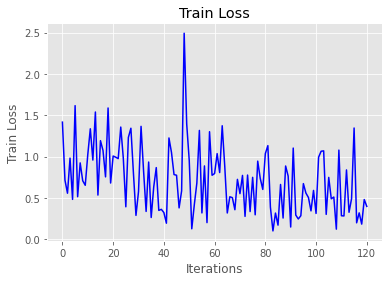

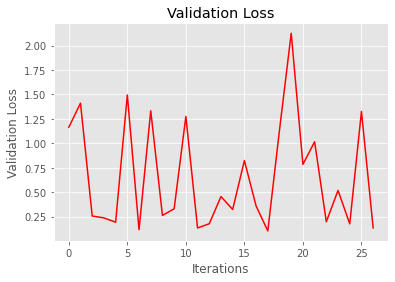

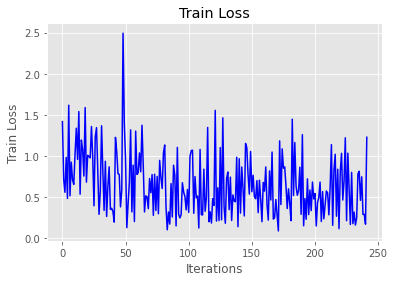

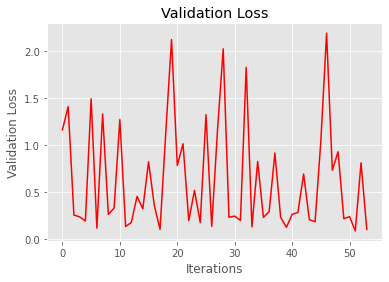

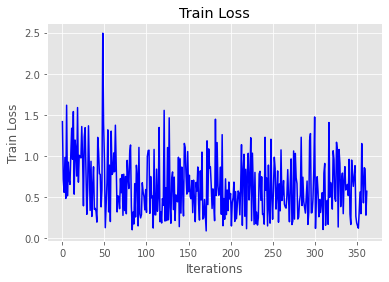

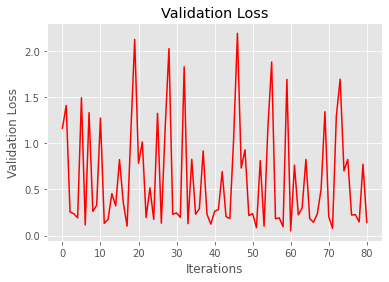

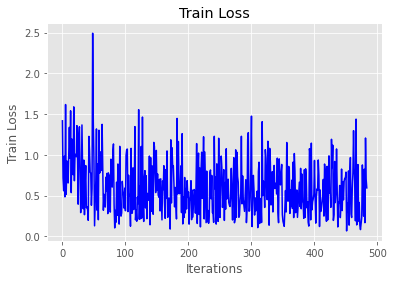

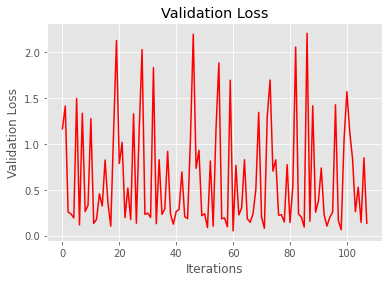

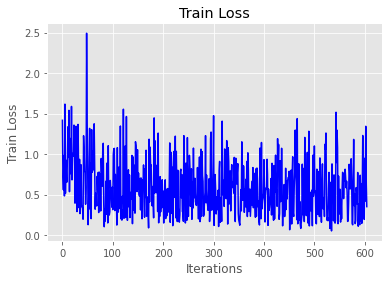

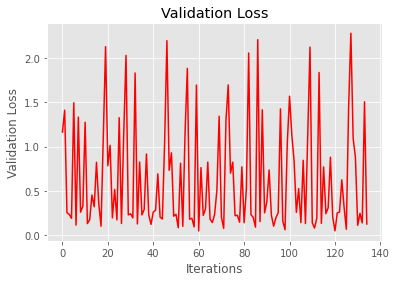

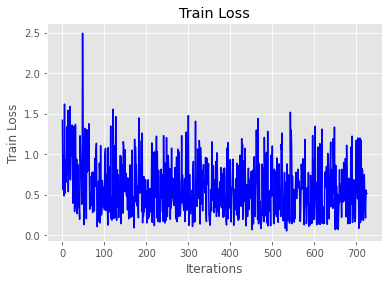

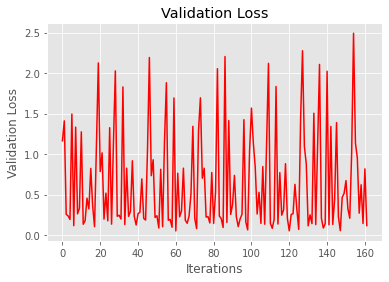

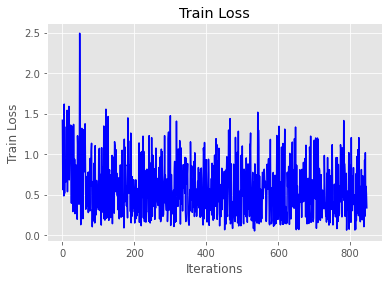

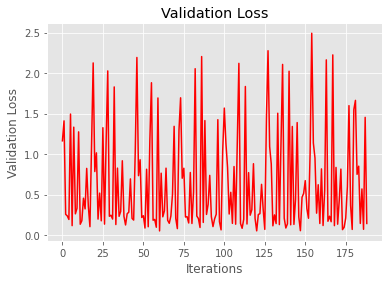

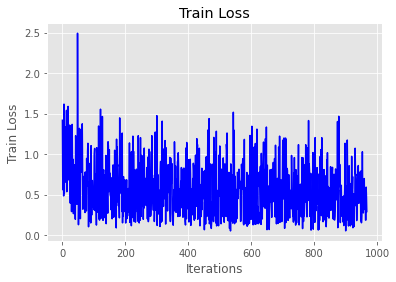

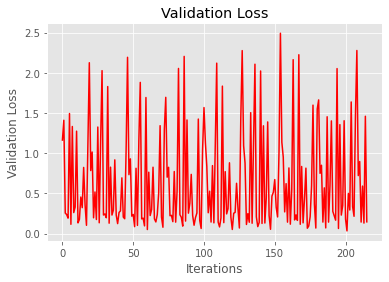

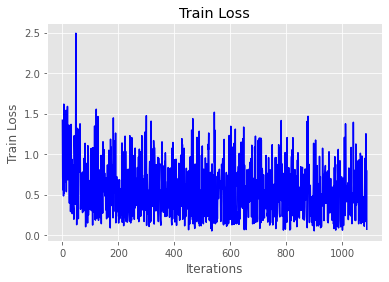

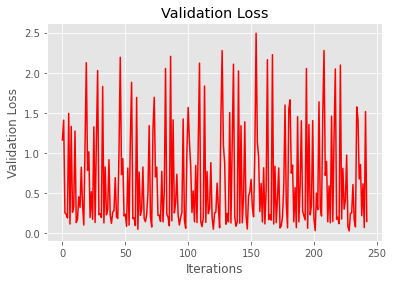

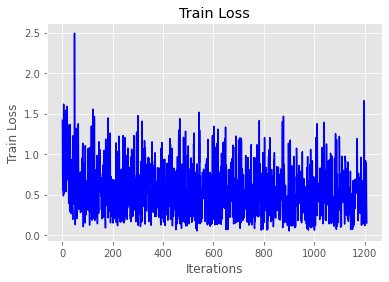

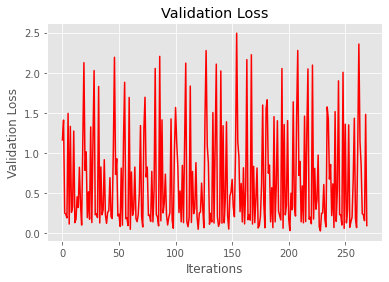

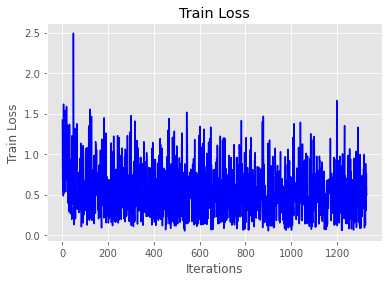

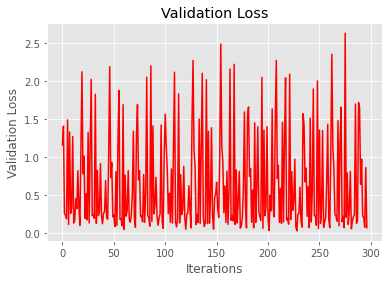

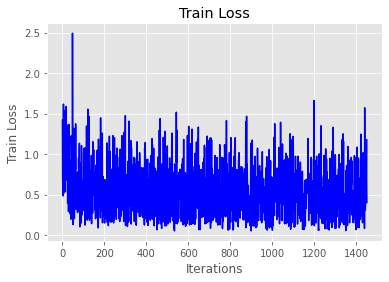

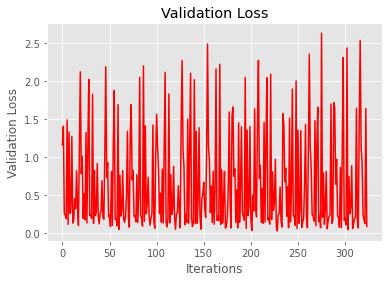

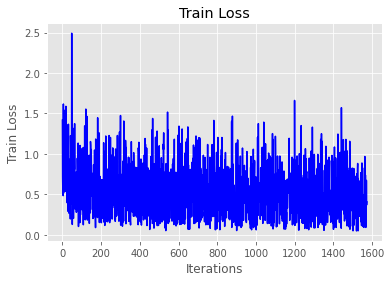

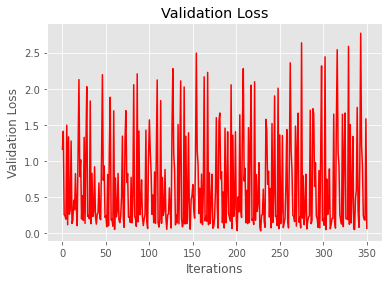

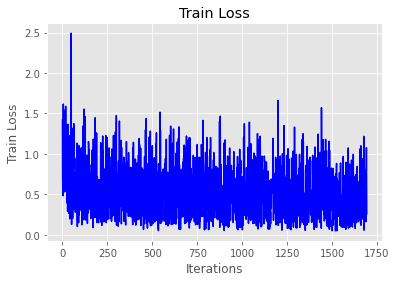

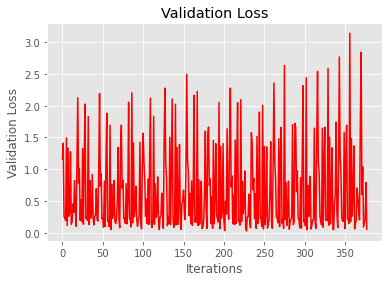

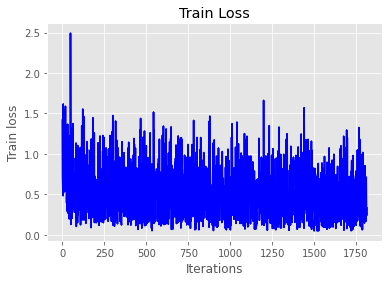

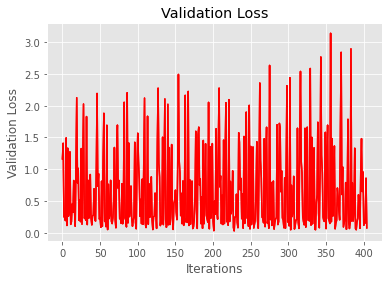

In [59]:
if __name__ == '__main__':
    # initialize the model and move to the computation device
    model3 = create_model(num_classes=NUM_CLASSES)
    model3 = model3.to(DEVICE)
    # get the model parameters
    params = [p for p in model3.parameters() if p.requires_grad]
    # define the optimizer
    optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
    # initialize the Averager class
    train_loss_hist = Averager()
    val_loss_hist = Averager()
    train_itr = 1
    val_itr = 1
    # train and validation loss lists to store loss values of all...
    # ... iterations till ena and plot graphs for all iterations
    train_loss_list = []
    val_loss_list = []
    # name to save the trained model with
    MODEL_NAME = 'model'
    # start the training epochs
    for epoch in range(NUM_EPOCHS):
        print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
        # reset the training and validation loss histories for the current epoch
        train_loss_hist.reset()
        val_loss_hist.reset()
        # create two subplots, one for each, training and validation
        figure_1, train_ax = plt.subplots()
        figure_2, valid_ax = plt.subplots()
        # start timer and carry out training and validation
        start = time.time()
        train_loss = train(train_loader, model3)
        val_loss = validate(valid_loader, model3)

        print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
        print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
        if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
            torch.save(model3.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
            print('SAVING MODEL COMPLETE...\n')
        
        if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # save loss plots after n epochs
            train_ax.plot(train_loss, color='blue')
            train_ax.set_xlabel('Iterations')
            train_ax.set_ylabel('Train Loss')
            train_ax.set_title('Train Loss')
            valid_ax.plot(val_loss, color='red')
            valid_ax.set_xlabel('Iterations')
            valid_ax.set_ylabel('Validation Loss')
            valid_ax.set_title('Validation Loss')
            figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
            figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
            print('SAVING PLOTS COMPLETE...')
        
        if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
            train_ax.plot(train_loss, color='blue')
            train_ax.set_xlabel('Iterations')
            train_ax.set_ylabel('Train loss')
            train_ax.set_title('Train Loss')
            valid_ax.plot(val_loss, color='red')
            valid_ax.set_xlabel('Iterations')
            valid_ax.set_ylabel('Validation Loss')
            valid_ax.set_title('Validation Loss')
            figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
            figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
            torch.save(model3.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        
        #plt.close('all')

In [ ]:
#ap = cv2.VideoCapture("/content/Final-Project/final.mp4")

cap = cv2.VideoCapture("/content/Pedestrian/Test_Project1.mp4")
fourcc = cv2.VideoWriter_fourcc(*'XVID')

#out = cv2.VideoWriter('output.avi', fourcc, 30.0, (1920, 1080))
out = cv2.VideoWriter('output.avi', fourcc, 30.0, (4496,3000))
i = 1
while cap.isOpened():
  print(i)
  ret, frame = cap.read()
  if ret:
    if i < 152:
      out.write(frame)
      i += 1
      continue
    elif i > 451 and i < 512:
      out.write(frame)
      i += 1
      continue     
    elif i > 748 and i < 809:
      out.write(frame)
      i += 1
      continue   
    elif i > 1078 and i < 1139:
      out.write(frame)
      i += 1
      continue   
    elif i > 1378 and i < 1439:
      out.write(frame)
      i += 1
      continue   
    elif i > 1661 and i < 1722:
      out.write(frame)
      i += 1
      continue   
    else:
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

      val_tran = get_transforms(train=False)
      im_pil = Image.fromarray(frame)
      im_pil = val_tran(im_pil)

      image = im_pil.to(device)
      model_val = model.eval()
      output = model([image])
      scores = output[0]['scores'].detach().cpu().numpy()
      num_people = len(scores[scores > 0.6])

      boxes = output[0]['boxes'].detach().cpu().numpy()
      boxes = boxes[:num_people]

      for j in range(num_people):
        frame = cv2.rectangle(frame, (boxes[j][0], boxes[j][1]), (boxes[j][2], boxes[j][3]), (0, 255, 0), thickness=10)
        frame = cv2.putText(frame, "score: {:.3f}".format(scores[j]), (boxes[j][0], int(boxes[j][1] - 50)),
                          cv2.FONT_HERSHEY_PLAIN, 3, (0, 255, 0), thickness=5)

      frame = cv2.putText(frame,"Number of people: {}".format(num_people), (50, 100),
                        cv2.FONT_HERSHEY_COMPLEX, 5, (255, 0, 0), thickness=15)
      
      frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
      out.write(frame)
      i += 1 

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
  if i > 2021 :
    cap.release()
    cv2.destroyAllWindows()
    break

Streaming output truncated to the last 5000 lines.
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
275
2